## Enrichment for eQTLs in ASE variants

In [1]:
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(gplots))

home    ='/home/paola/Family1070/private_output'
setwd(home)
ase_dir  = "ASE_chip/correlationWithBeta/"
gtex_dir = "Enrichment_annotations/GTEx/"

nm  = c('NKX25','H3K27AC_CM', 'H3K27AC_IPSC' )
QTL = paste (nm, "_eQTLs.txt", sep="") 
ASE =  paste ("ASE.tested", nm, "txt", sep=".") 
rsvar = paste ("rs.variants", nm, "txt", sep=".") 


In [5]:
#### Get eQTLS from GTEX overlapping all variants tested in each dataset

for ( i in 1:length(nm)){
    command = paste ("fgrep -w -f ", ase_dir, rsvar[i], " /publicdata/haploreg_v4.1_eqtls/eqtls_v4.1.tsv > ", gtex_dir, QTL[i], sep="")
    system(command)
}



### Arrange eQTLs in tabular format
long process

In [9]:
for(i in 1:length(nm)){
 
  cat(nm[i] ,"\n")
  
  ase = read.table(paste(ase_dir, ASE[i], sep=""),header=T)
  hap = read.table(paste(gtex_dir, QTL[i], sep=""), header=F, sep="\t", fill=T)
  colnames(hap)=c( "id", "qtl")
  
  ############
  
  x<-sapply(hap$qtl, str_count, ";")
  
  test=str_split_fixed(hap$qtl, ";", max(x))
  
  #preallocate matrix is faster
  
  nr=(dim(test)[1]*dim(test)[2])-sum(test=="")
  newmat=matrix(NA, nrow=nr, ncol=2)
  k=1
  for (a in 1:nrow(test)){
    for(j in 1:ncol(test)){
      if(test[a,j]!="") {
        newmat[k,1]<-as.vector(hap$id)[a]
        newmat[k,2]<-test[a,j]
        k=k+1
      }
    }
  }
  
  
  tfx<-data.frame(str_split_fixed(newmat[,2], "\\,",4 ))
  colnames(tfx)<-c("study", "tissue", "gene", "pval")
  tfx$snpID<-newmat[,1]
  tfx$tiss=substr(tfx$tissue, 1, 4)
  
  write.table(tfx, paste(gtex_dir, nm[i], ".eQTLsTable_hreg.txt", sep=""), col.names=T, row.names=F, quote=F, sep="\t") 
  
  tfx$snp_gene<-paste(tfx$snpID, tfx$gene, sep="_")
  tfx<-subset(tfx, tfx$study=="GTEx2015_v6")
  tfx$tiss<-as.factor(tfx$tiss)
  
  tot<-aggregate(snpID~snp_gene, tfx, length)
  
for (p in 1:length(levels(tfx$tiss))) {
    tix=levels(tfx$tiss)[p]
    cat(tix)
    tot2<-aggregate((tiss==tix)~snp_gene, tfx, sum)
    tot[, p+2]<-tot2[,2]
  }
 
  tot[,(p+3):(p+4)]<-str_split_fixed(tot[,1], "\\_",2 )
  colnames(tot)[2:length(tot)]<-c("total",levels(as.factor(tfx$tiss)), "snpID", "gene")
  
  write.table(tot, paste(gtex_dir, nm[i], ".GtexTable_hreg_aggregate.txt", sep=""), col.names=T, row.names=F, quote=F, sep="\t") #aggregate per snp
}


### Calculate enrichment between variants with and without ASE using Fisher tests

In [4]:
#n.tissues<-length(levels(tfx$tiss))
n.tissues<-26

In [8]:
cardips_eqtls<-read.table("/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_processing/eqtls01/gene_variant_pairs.tsv", 
                header=T, fill=T, stringsAsFactors=F, sep="\t")
# head(cardips_eqtls)

In [10]:
for( i in 1:length(nm)) {
   cat(nm[i])
    
  ase   = read.table (paste(ase_dir, ASE[i], sep=""),header=T)
  eqtls = read.table (paste(gtex_dir, nm[i], ".eQTLsTable_hreg.txt", sep=""), header=T, sep="\t")
  gtex  = read.table (paste(gtex_dir, nm[i], ".GtexTable_hreg_aggregate.txt", sep=""), header=T)
  
      
  ase$all_eQTLs<-ase$snpID %in% eqtls$snpID 
  ase$all_eQTLs[ase$snpID=="."]<-NA
  
  ase$cardipsQTLs<-ase$snpID %in% cardips_eqtls$rsid
  ase$cardipsQTLs[ase$rsSNP=="."]<-NA
   
for (q in 1:2){   
  mat<-ase[,c("snpID", "combined_fdr", "locus", "all_eQTLs", "cardipsQTLs")]
  ncols<-ncol(mat)  

    
  for (p in 1:n.tissues) {
      # condition 1 tissue specific = more than half come from a tissue group
  if(q==1) {tissue_specific<-subset(gtex, ((gtex[,2]/2)-gtex[,(p+2)])<=0)} 
      # condition 2 tissue specific = presence in a tissue
  if(q==2) {tissue_specific<-subset(gtex, gtex[,(p+2)]>0)}
      
  mat[,(length(mat)+1)]<-mat$snpID %in% tissue_specific$snpID
  mat[,length(mat)][mat$snpID=="."]<-NA
  
  }
  colnames(mat)[(ncols+1):length(mat)]<-colnames(gtex)[3:28]
  

  
 results=data.frame()
  
  for(f in 4:ncol(mat)) {
     
        mat<-mat[order(mat$combined_fdr),]
        mat<-mat[!duplicated(mat$locus),]
            # use only one snp per peak
      
      fi=fisher.test(table(mat$combined_fdr<0.05, mat[,f]>0))
   
      results[1:4,f-3]<-as.vector(table(mat$combined_fdr<0.05, mat[,f]>0))
      results[5,f-3]<-fi$estimate
      results[6,f-3]<-fi$p.value
      
    
  }
 results[7,]<-p.adjust(results[6,], method="BH")
 colnames(results)<-colnames(mat)[4:ncol(mat)]
  if(q==1) {write.csv(results, paste(gtex_dir,"Enrichment_for_tissue_specific_eQTLs.", nm[i], ".csv", sep=""), row.names=F)}
  if(q==2) {write.csv(results, paste(gtex_dir,"Enrichment_for_tissue_eQTLs.", nm[i], ".csv", sep=""), row.names=F)}
  
}
    
      }
      

### Plot Results with heatmap
Only when analyzing tissue-specific eQTLs we observe a significant enrichment for tissue

In [5]:
nm  = c('H3K27AC_IPSC' ,'H3K27AC_CM', 'NKX25' )

Warning message in heatmap.2(m, Colv = F, Rowv = T, srtRow = 0, srtCol = 45, offsetRow = -1, :
“Discrepancy: Colv is FALSE, while dendrogram is `both'. Omitting column dendogram.”

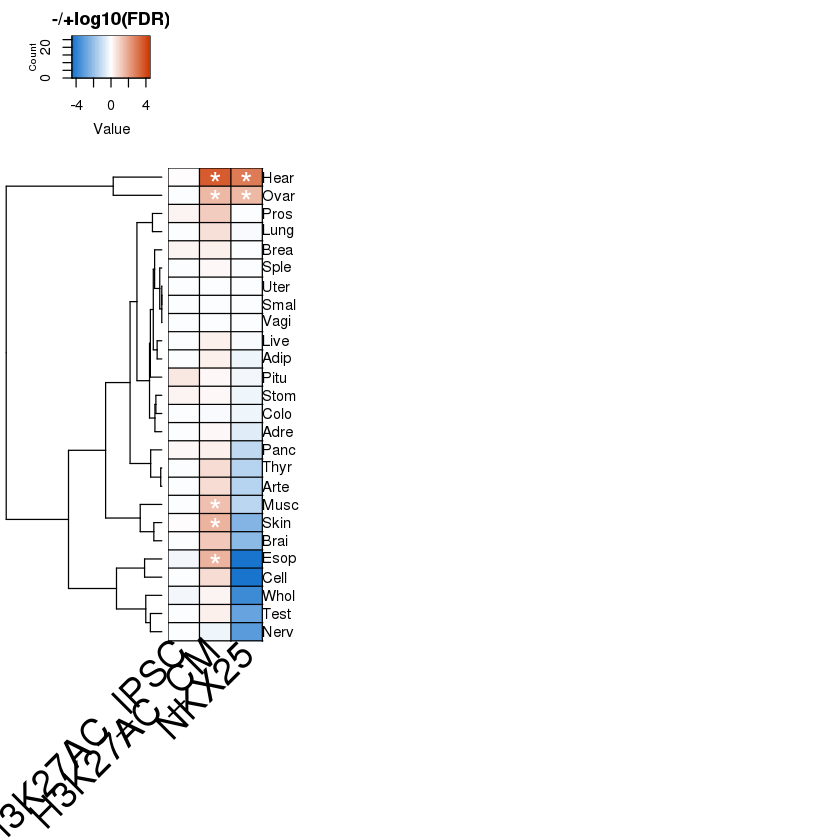

In [6]:
#pdf(paste(gtex_dir,"Enrichment_for_tissue_specific_eQTLs_heatmap.pdf", sep=""))


BH=data.frame()
OR=data.frame()
N = data.frame()
for (i in 1:length(nm)){
 res=read.csv(paste(gtex_dir,"Enrichment_for_tissue_specific_eQTLs.", nm[i], ".csv", sep=""), header=T)

  OR<-rbind(OR,res[5,-c(1:2)])
  BH<-rbind(BH,res[7,-c(1:2)])
  
}
rownames(OR)<-rownames(BH)<-nm

m<-as.matrix(t(-log(BH,10)*(c(1,-1)[(-log(OR,2)>0)+1])   ))

asterix = m
asterix[asterix<1.301]<-NA
asterix[asterix>1.301]<-"*"

my_palette <- colorRampPalette(c("dodgerblue3" ,"white","orangered3" ))(n = 100)
heatmap.2(m,Colv=F,Rowv=T, srtRow=0, srtCol=45, offsetRow=-1, offsetCol=-0.5,
          keysize=1, margins =c(10,29), trace="none",key.title="-/+log10(FDR)", tracecol=NA,
          col=my_palette, cellnote=asterix, notecol="white", notecex=2,
          sepwidth=c(0.0005,0.0005),sepcolor="black",colsep=0:nrow(BH),rowsep=0:ncol(BH))


 #dev.off()

